# Import necessary modules

In [1]:
import tensorflow as tf

import numpy as np
import os
import time
from tqdm import tqdm
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Load dataset

In [2]:
path_to_file = "text_generation.txt"

# Read the data

In [3]:
# Used for english processing
# UTF8 Decoder is a variable-length character decoding that can make any Unicode character readable. 
# Each Unicode character is made readable using 1-4 bytes. UTF-8 is the most common Unicode decoding

text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(text)} characters')

Length of text: 634622 characters


In [4]:
# text_list = text.split("\r\n\r\n\r\n")
# print(len(text_list))
# text_list[10]

In [103]:
text[-1200:]

'ger]\r\n\r\n\r\nLeave Denial Response:\r\n\r\nDear [Employee],\r\n\r\nThank you for your leave request. Unfortunately, after careful consideration, we are unable to approve your request for leave during the requested period.\r\n\r\nThis decision has been made due to [reason for denial]. We understand that this may cause some inconvenience, and we apologize for any disruption this may cause to your plans.\r\n\r\nPlease let us know if there are any alternative arrangements that could be made, or if there are any particular concerns or issues that you would like to discuss.\r\n\r\nThank you for your understanding and cooperation.\r\n\r\nBest regards,\r\n[Manager]\r\n\r\n\r\nLeave Extension Approval Response:\r\n\r\nDear [Employee],\r\n\r\nThank you for your request for an extension of your leave period from [leave start date] to [new leave end date]. After careful consideration, we are pleased to inform you that your request has been approved.\r\n\r\nPlease ensure that all necessary arra

# Data pre-processing

In [6]:
text = text[:99991]
text = text * 6
text = text[:-6]
print(len(text))

text[-100:]

599940


' continued restful and enjoyable leave, and look forward to your return.\r\n\r\nBest regards,\r\n[Manager]'

In [7]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


# Tokanization

In [8]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

# Vectorization
convert each character into a numeric ID

In [9]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

# joining
tf.strings.reduce_join to join the characters back into strings.

In [10]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

 tf.data.Dataset.from_tensor_slices function to convert the text vector into a stream of character indices.


In [11]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(599940,), dtype=int64, numpy=array([30, 43, 55, ..., 43, 56, 38], dtype=int64)>

In [12]:
type(all_ids)

tensorflow.python.framework.ops.EagerTensor

In [13]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [14]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'), ids)

R tf.Tensor(30, shape=(), dtype=int64)
e tf.Tensor(43, shape=(), dtype=int64)
q tf.Tensor(55, shape=(), dtype=int64)
u tf.Tensor(59, shape=(), dtype=int64)
e tf.Tensor(43, shape=(), dtype=int64)
s tf.Tensor(57, shape=(), dtype=int64)
t tf.Tensor(58, shape=(), dtype=int64)
  tf.Tensor(3, shape=(), dtype=int64)
f tf.Tensor(44, shape=(), dtype=int64)
o tf.Tensor(53, shape=(), dtype=int64)


In [15]:
seq_length = 150

batch method converts these individual characters to sequences of the desired size.

In [16]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True, )

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'R' b'e' b'q' b'u' b'e' b's' b't' b' ' b'f' b'o' b'r' b' ' b'M' b'a'
 b't' b'e' b'r' b'n' b'i' b't' b'y' b' ' b'L' b'e' b'a' b'v' b'e' b':'
 b'\r' b'\n' b'\r' b'\n' b'D' b'e' b'a' b'r' b' ' b'[' b'M' b'a' b'n' b'a'
 b'g' b'e' b'r' b"'" b's' b' ' b'N' b'a' b'm' b'e' b']' b',' b'\r' b'\n'
 b'\r' b'\n' b'I' b' ' b'a' b'm' b' ' b'w' b'r' b'i' b't' b'i' b'n' b'g'
 b' ' b't' b'o' b' ' b'i' b'n' b'f' b'o' b'r' b'm' b' ' b'y' b'o' b'u'
 b' ' b't' b'h' b'a' b't' b' ' b'I' b' ' b'w' b'i' b'l' b'l' b' ' b'b'
 b'e' b' ' b't' b'a' b'k' b'i' b'n' b'g' b' ' b'm' b'a' b't' b'e' b'r'
 b'n' b'i' b't' b'y' b' ' b'l' b'e' b'a' b'v' b'e' b' ' b's' b't' b'a'
 b'r' b't' b'i' b'n' b'g' b' ' b'f' b'r' b'o' b'm' b' ' b'[' b'S' b't'
 b'a' b'r' b't' b' ' b'D' b'a' b't' b'e' b']' b' ' b'u'], shape=(151,), dtype=string)


In [17]:
type(sequences)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b"Request for Maternity Leave:\r\n\r\nDear [Manager's Name],\r\n\r\nI am writing to inform you that I will be taking maternity leave starting from [Start Date] u"
b'ntil [End Date]. As per the company policy, I am entitled to [Duration of Leave] weeks of maternity leave.\r\n\r\nI have completed all my pending work and '
b'have handed over my responsibilities to [Name of Colleague/Team Member]. I have also shared my contact details with them in case of any emergency.\r\n\r\nD'
b'uring my absence, I can be reached via [Email/Phone Number] if there is any work-related emergency that requires my attention. Otherwise, I will be out'
b' of office.\r\n\r\nThank you for your understanding and support during this time. I look forward to returning to work and continuing to contribute to the s'


For training need a dataset of (input, label) pairs. 

Where input and label are sequences. 

At each time step the input is the current character and the label is the next character.

In [19]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [20]:
sequences

<BatchDataset element_spec=TensorSpec(shape=(151,), dtype=tf.int64, name=None)>

In [21]:
dataset = sequences.map(split_input_target)

dataset

<MapDataset element_spec=(TensorSpec(shape=(150,), dtype=tf.int64, name=None), TensorSpec(shape=(150,), dtype=tf.int64, name=None))>

########################################################################################

In [22]:
# text_list = [op.replace("\r","").replace("\n","") for op in text_list]
# text_list[0]

In [23]:
# all_sequences = []
# for text_line in tqdm(text_list):
#     # print(text_line)
#     for i in range(len(text_line)-seq_length):
#         seq = text_line[i:i+seq_length+1]
#         # print(seq, len(seq))
#         all_sequences.append(seq)

# print(len(text_list), len(all_sequences), all_sequences[1500], len(all_sequences[1500]))   

In [24]:
# f1 = open("final_dataset.txt", "w", encoding="utf-8")

# for i in tqdm(all_sequences):
#     f1.write(i)
# f1.close()

In [25]:
# final_text = open("final_dataset.txt", 'rb').read().decode(encoding='utf-8')
# print(f'Length of text: {len(final_text)} characters')

# print(len(final_text))

In [26]:
# vocab2 = sorted(set(final_text))
# print(f'{len(vocab2)} unique characters')

In [27]:
# ids_from_chars2 = tf.keras.layers.StringLookup(
#     vocabulary=list(vocab2), mask_token=None)

In [28]:
# chars_from_ids2 = tf.keras.layers.StringLookup(
#     vocabulary=ids_from_chars2.get_vocabulary(), invert=True, mask_token=None)

In [29]:
# all_ids2 = ids_from_chars2(tf.strings.unicode_split(final_text, 'UTF-8'))
# all_ids2

In [30]:
# ids_dataset2 = tf.data.Dataset.from_tensor_slices(all_ids2)

In [31]:
# for ids2 in ids_dataset2.take(10):
#     print(chars_from_ids2(ids2).numpy().decode('utf-8'), ids2)

In [32]:
# sequences2 = ids_dataset2.batch(seq_length+1, drop_remainder=True)

# for seq2 in sequences2.take(3):
#   print(chars_from_ids2(seq2))

In [33]:
# type(sequences2)

In [34]:
# def text_from_ids2(ids2):
#   return tf.strings.reduce_join(chars_from_ids2(ids2), axis=-1)

In [35]:
# for seq2 in sequences2.take(5):
#   print(text_from_ids2(seq2).numpy())

In [36]:
# def split_input_target2(sequence2):
#     input_text2 = sequence2[:-1]
#     target_text2 = sequence2[1:]
#     return input_text2, target_text2

In [37]:
# dataset2 = sequences2.map(split_input_target2)

# dataset2

In [38]:
# for input_example, target_example in dataset2.take(1):
#     print("Input :", text_from_ids2(input_example).numpy())
#     print("Target:", text_from_ids2(target_example).numpy())

In [39]:
# # Batch size
# BATCH_SIZE = 16#4

# # Buffer size to shuffle the dataset
# BUFFER_SIZE = 100

# dataset2 = (
#     dataset2
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE, drop_remainder=True)
#     .prefetch(tf.data.experimental.AUTOTUNE))

# dataset2

In [40]:
# # Length of the vocabulary in StringLookup Layer
# vocab_size2 = len(ids_from_chars2.get_vocabulary())

# # The embedding dimension
# embedding_dim2 = 256

# # Number of RNN units
# rnn_units2 = 1024

In [41]:
# class MyModel2(tf.keras.Model):
#   def __init__(self, vocab_size, embedding_dim, rnn_units):
#     super().__init__(self)
#     self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True,return_state=True, dropout=0.2)
   
#     self.gru2 = tf.keras.layers.GRU(rnn_units, return_sequences=True,return_state=True, dropout=0.2)

#     self.gru3 = tf.keras.layers.GRU(rnn_units, return_sequences=True,return_state=True, dropout=0.2)

#     self.dense = tf.keras.layers.Dense(vocab_size)

#   def call(self, inputs, states=None, return_state=False, training=False):
#     x = inputs
#     x = self.embedding(x, training=training)
#     if states is None:
#       states = self.gru.get_initial_state(x)
#     x, states = self.gru(x, initial_state=states, training=training)
    
#     x, states = self.gru2(x, initial_state=states, training=training)

#     x, states = self.gru2(x, initial_state=states, training=training)
   
#     x = self.dense(x, training=training)

#     if return_state:
#       return x, states
#     else:
#       return x

In [42]:
# model = MyModel2(vocab_size=vocab_size2, embedding_dim=embedding_dim2, rnn_units=rnn_units2)

In [43]:
# for input_example_batch2, target_example_batch2 in dataset2.take(1):
#     print("building")
#     example_batch_predictions2 = model(input_example_batch2)
#     print(example_batch_predictions2.shape, "(batch_size, sequence_length, vocab_size)")

In [44]:
# model.summary()

In [45]:
# sampled_indices2 = tf.random.categorical(example_batch_predictions2[0], num_samples=1)
# sampled_indices2 = tf.squeeze(sampled_indices2, axis=-1).numpy()

In [46]:
# print("Input:\n", text_from_ids2(input_example_batch2[0]).numpy())
# print()
# print("Next Char Predictions:\n", text_from_ids2(sampled_indices2).numpy())

In [47]:
# loss2 = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [48]:
# example_batch_mean_loss2 = loss2(target_example_batch2, example_batch_predictions2)
# print("Prediction shape: ", example_batch_predictions2.shape, " # (batch_size, sequence_length, vocab_size)")
# print("Mean loss:        ", example_batch_mean_loss2)

In [49]:
# tf.exp(example_batch_mean_loss2).numpy()

In [50]:
# model.compile(optimizer='adam', loss=loss2)

In [51]:
# class CustomTraining2(MyModel2):
#   @tf.function
#   def train_step(self, inputs):
#       inputs, labels = inputs
#       with tf.GradientTape() as tape:
#           predictions = self(inputs, training=True)
#           loss = self.loss(labels, predictions)
#       grads = tape.gradient(loss, model.trainable_variables)
#       self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

#       return {'loss': loss}

In [52]:
# model = CustomTraining2(
#     vocab_size=len(ids_from_chars2.get_vocabulary()),
#     embedding_dim=embedding_dim2,
#     rnn_units=rnn_units2)

In [53]:
# model.compile(optimizer = tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [54]:
# for input_example_batch2, target_example_batch2 in dataset2.take(1):
#     print("building")
#     example_batch_predictions2 = model(input_example_batch2)
#     print(example_batch_predictions2.shape, "(batch_size, sequence_length, vocab_size)")

In [55]:
# model.summary()

In [56]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# adam_fine = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #20x smaller than standard

# early_stop=EarlyStopping(monitor='loss', mode='min', verbose=0, patience=15, restore_best_weights=True)
# # lrd = ReduceLROnPlateau(monitor = 'val_acc', mode="max", patience = 4,verbose = 1,factor = 0.50, min_lr = 1e-10)
# lrd = ReduceLROnPlateau(monitor = 'loss', patience = 3,verbose = 1, factor = 0.50, min_lr = 1e-10)
# mcp = ModelCheckpoint("model_weights" ,save_format="tf")

In [57]:
# history2 = model.fit(dataset2, epochs=20, callbacks=[early_stop, lrd, mcp])

In [58]:
# import matplotlib.pyplot as plt

# # Plot the loss graph
# plt.plot(history2.history['loss'])
# plt.title('Model Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show()

In [59]:
# class OneStep2(tf.keras.Model):
#   def __init__(self, model, chars_from_ids2, ids_from_chars2, temperature=0.1):
#     super().__init__()
#     self.temperature = temperature
#     self.model = model
#     self.chars_from_ids2 = chars_from_ids2
#     self.ids_from_chars2 = ids_from_chars2

#     # Create a mask to prevent "[UNK]" from being generated.
#     skip_ids = self.ids_from_chars2(['[UNK]'])[:, None]
#     sparse_mask = tf.SparseTensor(
#         # Put a -inf at each bad index.
#         values=[-float('inf')]*len(skip_ids),
#         indices=skip_ids,
#         # Match the shape to the vocabulary
#         dense_shape=[len(ids_from_chars2.get_vocabulary())])
#     self.prediction_mask = tf.sparse.to_dense(sparse_mask)

#   @tf.function
#   def generate_one_step(self, inputs, states=None):
#     # Convert strings to token IDs.
#     input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
#     input_ids = self.ids_from_chars2(input_chars).to_tensor()

#     # Run the model.
#     predicted_logits, states = self.model(inputs=input_ids, states=states,return_state=True)
#     # Only use the last prediction.
#     predicted_logits = predicted_logits[:, -1, :]
#     predicted_logits = predicted_logits/self.temperature
#     # Apply the prediction mask: prevent "[UNK]" from being generated.
#     predicted_logits = predicted_logits + self.prediction_mask

#     # Sample the output logits to generate token IDs.
#     # print("PL", dir(predicted_logits))
#     # print("PL2", predicted_logits.op)
#     predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
#     # predicted_ids = predicted_logits[:, 2:3]
#     # print("PI", predicted_ids.shape, predicted_ids)
#     predicted_ids = tf.squeeze(predicted_ids, axis=-1)

#     # predicted_ids = tf.squeeze(predicted_logits, axis=-1)

#     # Convert from token ids to characters
#     predicted_chars = self.chars_from_ids2(predicted_ids)

#     # Return the characters and model state.
#     return predicted_chars, states

In [60]:
# one_step_model2 = OneStep2(model, chars_from_ids2, ids_from_chars2)

In [61]:
# states = None
# subject_line = 'Request for Maternity Leave:'
# # subject_line = subject_line.replace(":", "")
# subject_line = subject_line.replace(".", "")
# # subject_line = subject_line.lower()

# next_char = tf.constant([subject_line])
# result = [next_char]

# for n in range(500):
#   # print(next_char)
#   next_char, states = one_step_model2.generate_one_step(next_char, states=states)
#   result.append(next_char)

# result = tf.strings.join(result)
# end = time.time()


# try:
#     op = result[0].numpy().decode('utf-8')
#     res = op[:op.index("\n\r\n\r\n")]
#     print(res, '\n\n' + '_'*80)
# except:
#    print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

############################################################################

In [62]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b"Request for Maternity Leave:\r\n\r\nDear [Manager's Name],\r\n\r\nI am writing to inform you that I will be taking maternity leave starting from [Start Date] "
Target: b"equest for Maternity Leave:\r\n\r\nDear [Manager's Name],\r\n\r\nI am writing to inform you that I will be taking maternity leave starting from [Start Date] u"


# Create training batches

In [63]:
# Batch size
BATCH_SIZE = 16#4

# Buffer size to shuffle the dataset
BUFFER_SIZE = 500

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 150), dtype=tf.int64, name=None), TensorSpec(shape=(16, 150), dtype=tf.int64, name=None))>

# Model building

In [64]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [65]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True,return_state=True)#, dropout=0.1)
   
    # self.gru2 = tf.keras.layers.GRU(rnn_units, return_sequences=True,return_state=True, dropout=0.2)

    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)

    x, states = self.gru(x, initial_state=states, training=training)
    
    # x, states = self.gru2(x, initial_state=states, training=training)
   
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [66]:
model = MyModel(vocab_size=vocab_size, embedding_dim=embedding_dim,rnn_units=rnn_units)

In [67]:
for input_example_batch, target_example_batch in dataset.take(1):
    print("building")
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "(batch_size, sequence_length, vocab_size)")

building
(16, 150, 66) (batch_size, sequence_length, vocab_size)


In [68]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [69]:
# list(dataset)

In [70]:
# list(dataset.take(1))

In [71]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [72]:
sampled_indices

array([33, 20, 65, 54, 47, 57, 57, 38, 40, 40, 38, 39, 29,  1, 10, 17, 35,
       54, 14, 38, 19, 52, 44, 35,  2,  7, 18, 62, 47, 25, 24, 38, 18, 21,
       32, 58, 51, 19, 63, 32, 47, 41, 10, 28, 47, 31,  3, 22, 13, 61, 39,
       20, 17,  2, 31,  3, 15, 64, 19, 48, 14,  6, 36,  5, 12,  4, 48, 28,
       34, 54, 45, 20, 57, 56, 25, 32,  4,  7, 11, 29, 35, 26, 51, 25, 16,
       17, 24, 57, 42, 37, 35, 32, 40, 22, 13, 11,  0,  2, 52, 33,  2, 38,
       37, 20, 54, 33, 37,  4, 28,  7, 19, 46, 51, 49, 14, 50, 12, 48, 52,
       64, 45, 44, 42, 40, 30, 48, 63, 15,  3, 13, 12, 59, 41, 35, 48,  6,
       28, 53, 45,  2, 21, 20, 41,  9, 33, 28, 38, 44, 57, 65],
      dtype=int64)

In [73]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ther steps I need to take to process my leave request.\r\n\r\nThank you for your understanding and support during this time.\r\n\r\nSincerely,\r\n[Your Name]\r\n\r'

Next Char Predictions:
 b"UF\xe2\x80\x99piss]bb]aP\n/CWp?]EnfW\r,DxiLJ]DGTtmEyTic/OiS H:waFC\rS AzEj?)Y(2'jOVpgFsrLT',1PWMmLBCJsd[WTbH:1[UNK]\rnU\r][FpU['O,Ehmk?l2jnzgfdbRjyA :2ucWj)Oog\rGFc.UO]fs\xe2\x80\x99"


# Train the model

In [74]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [75]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (16, 150, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1897154, shape=(), dtype=float32)


In [76]:
tf.exp(example_batch_mean_loss).numpy()

66.004005

In [77]:
model.compile(optimizer='adam', loss=loss)

In [78]:
# EPOCHS = 200
# history = model.fit(dataset, epochs=EPOCHS)

# Training customized model

In [79]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [80]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [81]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [82]:
for input_example_batch, target_example_batch in dataset.take(1):
    print("building")
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "(batch_size, sequence_length, vocab_size)")

building
(16, 150, 66) (batch_size, sequence_length, vocab_size)


In [83]:
model.summary()

Model: "custom_training"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [84]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

adam_fine = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #20x smaller than standard

early_stop=EarlyStopping(monitor='loss', mode='min', verbose=0, patience=15, restore_best_weights=True)
# lrd = ReduceLROnPlateau(monitor = 'val_acc', mode="max", patience = 4,verbose = 1,factor = 0.50, min_lr = 1e-10)
lrd = ReduceLROnPlateau(monitor = 'loss', patience = 3,verbose = 1, factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint("model_weights" ,save_format="tf")

In [85]:
history = model.fit(dataset, epochs=80, callbacks=[early_stop, lrd, mcp])

Epoch 1/80
247/248 [============================>.] - ETA: 0s - loss: 1.9058

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 10s 37ms/step - loss: 1.8966 - lr: 0.0010
Epoch 2/80
247/248 [============================>.] - ETA: 0s - loss: 0.5554

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.5538 - lr: 0.0010
Epoch 3/80
246/248 [============================>.] - ETA: 0s - loss: 0.2801

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.2796 - lr: 0.0010
Epoch 4/80
248/248 [==============================] - ETA: 0s - loss: 0.1792

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.1791 - lr: 0.0010
Epoch 5/80
247/248 [============================>.] - ETA: 0s - loss: 0.1411

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.1410 - lr: 0.0010
Epoch 6/80
247/248 [============================>.] - ETA: 0s - loss: 0.1218

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.1218 - lr: 0.0010
Epoch 7/80
248/248 [==============================] - ETA: 0s - loss: 0.1112

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.1112 - lr: 0.0010
Epoch 8/80
248/248 [==============================] - ETA: 0s - loss: 0.1033

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.1033 - lr: 0.0010
Epoch 9/80
246/248 [============================>.] - ETA: 0s - loss: 0.0982

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0981 - lr: 0.0010
Epoch 10/80
247/248 [============================>.] - ETA: 0s - loss: 0.0936

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0936 - lr: 0.0010
Epoch 11/80
246/248 [============================>.] - ETA: 0s - loss: 0.0918

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0918 - lr: 0.0010
Epoch 12/80
246/248 [============================>.] - ETA: 0s - loss: 0.0893

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0892 - lr: 0.0010
Epoch 13/80
247/248 [============================>.] - ETA: 0s - loss: 0.0864

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0864 - lr: 0.0010
Epoch 14/80
248/248 [==============================] - ETA: 0s - loss: 0.0850

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0850 - lr: 0.0010
Epoch 15/80
248/248 [==============================] - ETA: 0s - loss: 0.0832
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0832 - lr: 0.0010
Epoch 16/80
248/248 [==============================] - ETA: 0s - loss: 0.0680

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0680 - lr: 5.0000e-04
Epoch 17/80
247/248 [============================>.] - ETA: 0s - loss: 0.0646

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0646 - lr: 5.0000e-04
Epoch 18/80
247/248 [============================>.] - ETA: 0s - loss: 0.0635

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0635 - lr: 5.0000e-04
Epoch 19/80
248/248 [==============================] - ETA: 0s - loss: 0.0633
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0633 - lr: 5.0000e-04
Epoch 20/80
247/248 [============================>.] - ETA: 0s - loss: 0.0570

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0570 - lr: 2.5000e-04
Epoch 21/80
247/248 [============================>.] - ETA: 0s - loss: 0.0555

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0555 - lr: 2.5000e-04
Epoch 22/80
246/248 [============================>.] - ETA: 0s - loss: 0.0553

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0553 - lr: 2.5000e-04
Epoch 23/80
246/248 [============================>.] - ETA: 0s - loss: 0.0552
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0553 - lr: 2.5000e-04
Epoch 24/80
246/248 [============================>.] - ETA: 0s - loss: 0.0519

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0519 - lr: 1.2500e-04
Epoch 25/80
248/248 [==============================] - ETA: 0s - loss: 0.0510

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0510 - lr: 1.2500e-04
Epoch 26/80
246/248 [============================>.] - ETA: 0s - loss: 0.0507

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0507 - lr: 1.2500e-04
Epoch 27/80
246/248 [============================>.] - ETA: 0s - loss: 0.0505
Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0505 - lr: 1.2500e-04
Epoch 28/80
248/248 [==============================] - ETA: 0s - loss: 0.0485

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0486 - lr: 6.2500e-05
Epoch 29/80
247/248 [============================>.] - ETA: 0s - loss: 0.0480

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0480 - lr: 6.2500e-05
Epoch 30/80
247/248 [============================>.] - ETA: 0s - loss: 0.0478

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0478 - lr: 6.2500e-05
Epoch 31/80
246/248 [============================>.] - ETA: 0s - loss: 0.0476

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0476 - lr: 6.2500e-05
Epoch 32/80
248/248 [==============================] - ETA: 0s - loss: 0.0474
Epoch 32: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0474 - lr: 6.2500e-05
Epoch 33/80
248/248 [==============================] - ETA: 0s - loss: 0.0462

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0462 - lr: 3.1250e-05
Epoch 34/80
247/248 [============================>.] - ETA: 0s - loss: 0.0459

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0459 - lr: 3.1250e-05
Epoch 35/80
248/248 [==============================] - ETA: 0s - loss: 0.0457

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0457 - lr: 3.1250e-05
Epoch 36/80
248/248 [==============================] - ETA: 0s - loss: 0.0456

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0456 - lr: 3.1250e-05
Epoch 37/80
246/248 [============================>.] - ETA: 0s - loss: 0.0454

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0454 - lr: 3.1250e-05
Epoch 38/80
247/248 [============================>.] - ETA: 0s - loss: 0.0453
Epoch 38: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0453 - lr: 3.1250e-05
Epoch 39/80
248/248 [==============================] - ETA: 0s - loss: 0.0445

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0445 - lr: 1.5625e-05
Epoch 40/80
246/248 [============================>.] - ETA: 0s - loss: 0.0444

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0443 - lr: 1.5625e-05
Epoch 41/80
248/248 [==============================] - ETA: 0s - loss: 0.0443

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0443 - lr: 1.5625e-05
Epoch 42/80
246/248 [============================>.] - ETA: 0s - loss: 0.0442

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0442 - lr: 1.5625e-05
Epoch 43/80
248/248 [==============================] - ETA: 0s - loss: 0.0441
Epoch 43: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0441 - lr: 1.5625e-05
Epoch 44/80
246/248 [============================>.] - ETA: 0s - loss: 0.0437

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0436 - lr: 7.8125e-06
Epoch 45/80
246/248 [============================>.] - ETA: 0s - loss: 0.0436

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0436 - lr: 7.8125e-06
Epoch 46/80
246/248 [============================>.] - ETA: 0s - loss: 0.0435
Epoch 46: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0435 - lr: 7.8125e-06
Epoch 47/80
246/248 [============================>.] - ETA: 0s - loss: 0.0433

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0433 - lr: 3.9063e-06
Epoch 48/80
247/248 [============================>.] - ETA: 0s - loss: 0.0433

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0432 - lr: 3.9063e-06
Epoch 49/80
248/248 [==============================] - ETA: 0s - loss: 0.0432
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0432 - lr: 3.9063e-06
Epoch 50/80
247/248 [============================>.] - ETA: 0s - loss: 0.0431

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0431 - lr: 1.9531e-06
Epoch 51/80
247/248 [============================>.] - ETA: 0s - loss: 0.0431

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0431 - lr: 1.9531e-06
Epoch 52/80
248/248 [==============================] - ETA: 0s - loss: 0.0431
Epoch 52: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0431 - lr: 1.9531e-06
Epoch 53/80
248/248 [==============================] - ETA: 0s - loss: 0.0430

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0430 - lr: 9.7656e-07
Epoch 54/80
246/248 [============================>.] - ETA: 0s - loss: 0.0430

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0430 - lr: 9.7656e-07
Epoch 55/80
248/248 [==============================] - ETA: 0s - loss: 0.0430
Epoch 55: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0430 - lr: 9.7656e-07
Epoch 56/80
247/248 [============================>.] - ETA: 0s - loss: 0.0430

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0430 - lr: 4.8828e-07
Epoch 57/80
247/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0430 - lr: 4.8828e-07
Epoch 58/80
248/248 [==============================] - ETA: 0s - loss: 0.0430
Epoch 58: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0429 - lr: 4.8828e-07
Epoch 59/80
248/248 [==============================] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 2.4414e-07
Epoch 60/80
248/248 [==============================] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 2.4414e-07
Epoch 61/80
246/248 [============================>.] - ETA: 0s - loss: 0.0429
Epoch 61: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0429 - lr: 2.4414e-07
Epoch 62/80
246/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0430 - lr: 1.2207e-07
Epoch 63/80
248/248 [==============================] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 1.2207e-07
Epoch 64/80
247/248 [============================>.] - ETA: 0s - loss: 0.0430

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 1.2207e-07
Epoch 65/80
247/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0429 - lr: 1.2207e-07
Epoch 66/80
248/248 [==============================] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0429 - lr: 1.2207e-07
Epoch 67/80
248/248 [==============================] - ETA: 0s - loss: 0.0429
Epoch 67: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 1.2207e-07
Epoch 68/80
247/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0429 - lr: 6.1035e-08
Epoch 69/80
248/248 [==============================] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 37ms/step - loss: 0.0429 - lr: 6.1035e-08
Epoch 70/80
247/248 [============================>.] - ETA: 0s - loss: 0.0429
Epoch 70: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 6.1035e-08
Epoch 71/80
246/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 3.0518e-08
Epoch 72/80
246/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 3.0518e-08
Epoch 73/80
247/248 [============================>.] - ETA: 0s - loss: 0.0429
Epoch 73: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0429 - lr: 3.0518e-08
Epoch 74/80
246/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 1.5259e-08
Epoch 75/80
248/248 [==============================] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0429 - lr: 1.5259e-08
Epoch 76/80
246/248 [============================>.] - ETA: 0s - loss: 0.0429
Epoch 76: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 1.5259e-08
Epoch 77/80
246/248 [============================>.] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 7.6294e-09
Epoch 78/80
248/248 [==============================] - ETA: 0s - loss: 0.0429

INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 35ms/step - loss: 0.0429 - lr: 7.6294e-09
Epoch 79/80
248/248 [==============================] - ETA: 0s - loss: 0.0429
Epoch 79: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.


INFO:tensorflow:Assets written to: model_weights\assets


INFO:tensorflow:Assets written to: model_weights\assets


248/248 [==============================] - 9s 36ms/step - loss: 0.0429 - lr: 7.6294e-09


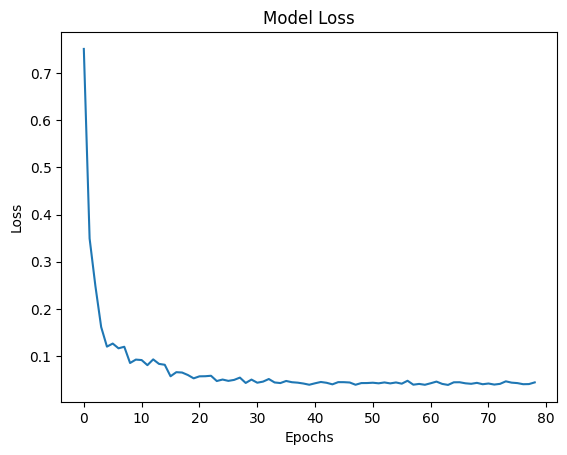

In [86]:
import matplotlib.pyplot as plt

# Plot the loss graph
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# prediction function

In [87]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.2):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    predicted_logits, states = self.model(inputs=input_ids, states=states,return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    # print("PL", dir(predicted_logits))
    # print("PL2", predicted_logits.op)
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    # predicted_ids = predicted_logits[:, 2:3]
    # print("PI", predicted_ids.shape, predicted_ids)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # predicted_ids = tf.squeeze(predicted_logits, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [88]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [98]:
states = None
subject_line = '''Request for Annual Leave:'''

# subject_line = subject_line.replace(":", "")
# subject_line = subject_line.replace(".", "")
# subject_line = subject_line.lower()

next_char = tf.constant([subject_line])
result = [next_char]

for n in range(800):
  # print(next_char)
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()


try:
    op = result[0].numpy().decode('utf-8')
    res = op[:op.index("\n\r\n\r\n")]
    print(res, '\n\n' + '_'*80)
except:
   print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)


Request for Annual Leave:

Dear [Manager's Name], 
I would like to request [number of days/weeks] of annual leave in advance starting from [start date] to [end date]. I understand that this request may have an impact on the team's workflow, and I will ensure that all of my work is handed over to a colleague. 
Thank you for your consideration.

Sincerely,
 Your Name]

________________________________________________________________________________


# Saving & Loading the model

In [90]:
tf.saved_model.save(one_step_model, 'GRU_MODEL')

INFO:tensorflow:Assets written to: GRU_MODEL\assets


INFO:tensorflow:Assets written to: GRU_MODEL\assets


In [91]:
one_step_reloaded = tf.saved_model.load('GRU_MODEL')

# Running prediction model in loop to generate the text

In [92]:
states = None
subject_line = 'Request for Maternity Leave'
# subject_line = subject_line.replace(":", "")
subject_line = subject_line.replace(".", "")
# subject_line = subject_line.lower()

next_char = tf.constant([subject_line])
result = [next_char]


for n in range(1000):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    # print(states)
    result.append(next_char)

op = tf.strings.join(result)[0].numpy().decode("utf-8")

try:
    print(op[:op.index("\n\r\n\r\n")])
except:
   print(op,"\n except block")

Request for Maternity Leave:

Dear [Manager's Name],

I am writing to inform you that I will be taking maternity leave starting from [Start Date] until [End Date]. As per the company policy, I am entitled to [Duration of Leave] weeks of maternity leave.

I have completed all my pending work and have handed over my responsibilities to [Name of Colleague/Team Member]. I have also shared my contact details with them in case of any emergency.

During my absence, I can be reached via [Email/Phone Number] if there is any work-related emergency that requires my attention. Otherwise, I will be out of office.

Thank you for your understanding and support during this time. I look forward to returning to work and continuing to contribute to the success of the company.

Sincerely,
[Your Name]


In [105]:
states = None
subject_line = 'Request for Leave due to Family Emergency'
# subject_line = subject_line.replace(":", "")
subject_line = subject_line.replace(".", "")
# subject_line = subject_line.lower()

next_char = tf.constant([subject_line])
result = [next_char]


for n in range(1000):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    # print(states)
    result.append(next_char)

op = tf.strings.join(result)[0].numpy().decode("utf-8")

try:
    print(op[:op.index("\n\r\n\r\n")])
except:
   print(op,"\n except block")

Request for Leave due to Family Emergency:

Dear [Manager's Name],

I am writing to request [number of days] of leave starting from [start date] due to a family emergency. Unfortunately, [name of family member] has been hospitalized and requires my immediate attention. I have attached a doctor's note for your records.

During my absence, I will ensure that my work is up to date and all outstanding tasks are delegated. I will also be available via email or phone if there are any urgent matters that require my attention.

Thank you for your understanding during this difficult time. Please let me know if you require any further information.

Sincerely,
[Your Name]


In [107]:
states = None
subject_line = 'Request for House Moving Leave'
# subject_line = subject_line.replace(":", "")
subject_line = subject_line.replace(".", "")
# subject_line = subject_line.lower()

next_char = tf.constant([subject_line])
result = [next_char]


for n in range(1000):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    # print(states)
    result.append(next_char)

op = tf.strings.join(result)[0].numpy().decode("utf-8")

try:
    print(op[:op.index("\n\r\n\r\n")])
except:
   print(op,"\n except block")

Request for House Moving Leave:

Dear [Manager's Name],

I am writing to request a house moving leave from [start date] to [end date]. Due to unforeseen circumstances, I have to move to a new house, and I need some time to make the necessary arrangements and settle in. I have completed all my pending work and made sure that my team has everything they need to carry on in my absence.

I have also discussed my leave with [colleague's name] and have ensured that all important tasks and projects will be covered while I am away. I will be available via email or phone in case of any urgent matters that require my attention.

Thank you for your understanding and support during my absence. I look forward to reconnecting with everyone and contributing to the team.

Best regards,
[Your Name]


In [108]:
states = None
subject_line = 'Request for Leave Extension:'
# subject_line = subject_line.replace(":", "")
subject_line = subject_line.replace(".", "")
# subject_line = subject_line.lower()

next_char = tf.constant([subject_line])
result = [next_char]


for n in range(1000):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    # print(states)
    result.append(next_char)

op = tf.strings.join(result)[0].numpy().decode("utf-8")

try:
    print(op[:op.index("\n\r\n\r\n")])
except:
   print(op,"\n except block")

Request for Leave Extension:

Dear [Manager's Name],
I am writing to request an extension of my leave period due to [reasons, e.g. illness, personal issues, etc.]. I would like to extend my leave by [number of days/weeks] starting from [start date]. 
Thank you for your understanding.

Sincerely,
[Your Name]


In [109]:
states = None
subject_line = 'Return from Remote Work Notification:'
# subject_line = subject_line.replace(":", "")
subject_line = subject_line.replace(".", "")
# subject_line = subject_line.lower()

next_char = tf.constant([subject_line])
result = [next_char]


for n in range(1000):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    # print(states)
    result.append(next_char)

op = tf.strings.join(result)[0].numpy().decode("utf-8")

try:
    print(op[:op.index("\n\r\n\r\n")])
except:
   print(op,"\n except block")

Return from Remote Work Notification:

Dear [Manager/Team],

I wanted to inform you that I have returned from working remotely and am now back in the office. Although I enjoyed the flexibility of remote work, I am excited to be back in the office and collaborating with my colleagues in person.

Please let me know if there are any updates or changes that I should be aware of, or if there are any tasks or projects that require my attention.

Thank you for your support during my time working remotely. I am looking forward to catching up with everyone and getting back to work.

Best regards,
[Your Name]


In [110]:
states = None
subject_line = 'Return from Flexible Work Notification:'
# subject_line = subject_line.replace(":", "")
subject_line = subject_line.replace(".", "")
# subject_line = subject_line.lower()

next_char = tf.constant([subject_line])
result = [next_char]


for n in range(1000):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    # print(states)
    result.append(next_char)

op = tf.strings.join(result)[0].numpy().decode("utf-8")

try:
    print(op[:op.index("\n\r\n\r\n")])
except:
   print(op,"\n except block")

Return from Flexible Work Notification:

Dear [Manager/Team],

I am writing to let you know that I have returned to the office after taking advantage of our company's flexible work arrangement. I appreciate the opportunity to work outside the office and have found the experience to be beneficial in terms of my productivity and work-life balance.

Please let me know if there are any updates or changes that I should be aware of, or if there are any outstanding tasks that require my attention.

Thank you for your understanding and support during my time working remotely. I look forward to reconnecting with everyone and contributing to the team.

Best regards,
[Your Name]
